# Fit Readout Weights

October 18, 2024

In [1]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils.readout_fit import *
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
Invoking __init__.py for NDNT.utils


## Load Data

In [2]:
# Load RF center and cell key
out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5' #'data/cloud_data_stim_dim80_robs_sqrad_0.1.hdf5'
with h5py.File(out_file, 'r') as f:
    x_pos = f['x_pos'][:]
    y_pos = f['y_pos'][:]
    cell_key = [str(f['cell_key'][:][i], encoding='utf-8') for i in range(x_pos.shape[0])]
    file_start_pos = list(f['file_start_pos'][:])

In [3]:
# Load Orientation info
ori_dict = np.load('data/V1_neuron_orientation_in_deg_and_orientation_selection_sqrad_0.3_GQM.pkl', allow_pickle=True)
L4_thetas = np.concatenate((ori_dict['thetas']['V1_Exc_L4'], ori_dict['thetas']['V1_Inh_L4']))
L4_osis = np.concatenate((ori_dict['osis']['V1_Exc_L4'], ori_dict['osis']['V1_Inh_L4']))
print(L4_thetas.shape)
print(L4_osis.shape)

(794,)
(794,)


In [4]:
# cell specific indices
LGN_idx = [i for i, val in enumerate(cell_key) if val == 'X_ON' or val == 'X_OFF']
V1_idx  = [i for i, val in enumerate(cell_key) if val == 'V1_Exc_L4' or val == 'V1_Inh_L4' or val == 'V1_Exc_L2/3' or val == 'V1_Inh_L2/3']
L4_idx  = [i for i, val in enumerate(cell_key) if val == 'V1_Exc_L4' or val == 'V1_Inh_L4']
print('LGN cells:', len(LGN_idx))
print('V1 cells:', len(V1_idx))
print('L4 cells:', len(L4_idx))

LGN cells: 214
V1 cells: 1491
L4 cells: 794


In [5]:
L4_cell_key = [cell_key[i] for i in L4_idx]
L4_exc_idx = [i for i, val in enumerate(L4_cell_key) if val == 'V1_Exc_L4']
L4_inh_idx = [i for i, val in enumerate(L4_cell_key) if val == 'V1_Inh_L4']

In [6]:
#out_file = 'data/cloud_data_stim_dim120_robs_sqrad_0.3.hdf5'
start    = time.time()
data     = SimCloudData(file_name=out_file, down_sample=2, cell_idx=L4_idx, num_lags=11)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 51.043377161026 sec


In [7]:
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
NC = data[0]['robs'].shape[1]
NT = data.NT
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)
print('Number of cells', NC)
print('Number of time points', NT)

stim_dims = [1, 60, 60, 1]
num_lags = 11
L = 60
Number of cells 794
Number of time points 510000


In [8]:
pxl_x_pos, pxl_y_pos = deg2pxl(x_pos[L4_idx], y_pos[L4_idx], L, down_sample=2)
mu0s = utils.pixel2grid(np.stack((pxl_x_pos,pxl_y_pos),axis=1), L=L)
print('Spatial mu0:', mu0s.shape)

Spatial mu0: (794, 2)


In [9]:
def degrees2mu(theta_deg, angles, continuous=True, max_angle=180 ):
    """
    Converts degrees into mu-values. If to_output=True, outputs to an array, and otherwise
    stores in the Qmu variable. It detects whether half-circle of full circle using stored angle values
        
    Args:
        theta_deg (np array): array of angles in degrees into mu values, based on 180 or 360 deg wrap-around
        continuous (Boolean): whether to convert to continuous angle or closest "integer" mu value (def True, continuous)
        max_angle: maximum angle represented in OriConv layers (default 180, but could be 360)
    Returns:
        Qmus: as numpy-array, if to_output is set to True, otherwise, nothing 
    """
    num_angles = len(angles)

    # convert inputs to np.array
    if not isinstance(theta_deg, np.ndarray):
        theta_deg = np.array(theta_deg, dtype=np.float32)
    if not continuous:
        dQ = max_angle/num_angles
        theta_deg = dQ * np.round(theta_deg/dQ)
    theta_deg = (theta_deg%max_angle)  # map between 0 and max_angle

    mu_offset = 1/num_angles # first bin at 0 degrees is actually a shifted mu value (not right at edge)
    Qmus = (theta_deg-max_angle/2) / (max_angle/2) + mu_offset
    Qmus[Qmus <= -1] += 2
    Qmus[Qmus > 1] += -2
    
    return Qmus

In [10]:
angles = np.arange(0, 180, 30).astype(int)
Qmu0s = degrees2mu(L4_thetas, angles)
print('Angle mu0:', Qmu0s.shape)

Angle mu0: (794,)


## Load Model

In [20]:
cnn = NDN.load_model_zip('models/1016_three_layer_model_ORICONV_CNN_L4_None_maxreg.ndn')
cnn.block_sample = True
cnn.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([3610, 2])
  Layer 1:
      weight: torch.Size([722, 12])
  Layer 2:
      NOT FIT: weight: torch.Size([1, 1])
  Layer 3:
      weight: torch.Size([300, 8])
Network 1:
  Layer 0:
      weight: torch.Size([20, 794])
      bias: torch.Size([794])
      mu: torch.Size([794, 2])
      sigma: torch.Size([794, 1])
      Qmu: torch.Size([794, 1])
      Qsigma: torch.Size([794, 1])


In [21]:
LL = cnn.eval_models(data, data_inds=data.val_blks, device=device, batch_size=3, null_adjusted=True)
print('Log Likelyhood shape', LL.shape)

Eval models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:17<00:00,  1.96it/s]

Log Likelyhood shape (794,)


L4 Exc Mean LL: 0.6381214 L4 Inh Mean LL: 0.5228307


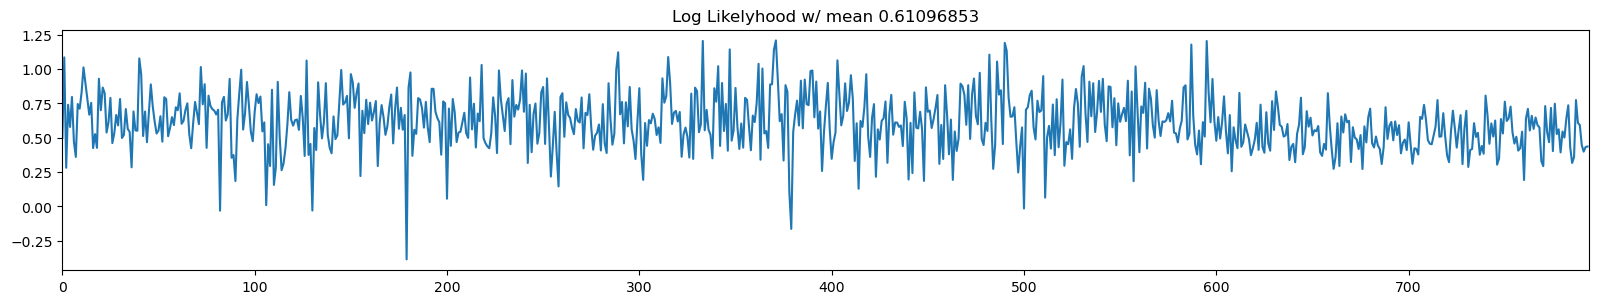

In [22]:
print('L4 Exc Mean LL:', np.mean(LL[L4_exc_idx]), 'L4 Inh Mean LL:', np.mean(LL[L4_inh_idx]))
ss()
#plt.plot([0,NC],[0,0], 'k')
plt.plot(LL)
plt.title('Log Likelyhood w/ mean '+str(np.mean(LL)))
plt.xlim([0,NC])
#plt.ylim([0,1])
plt.show()

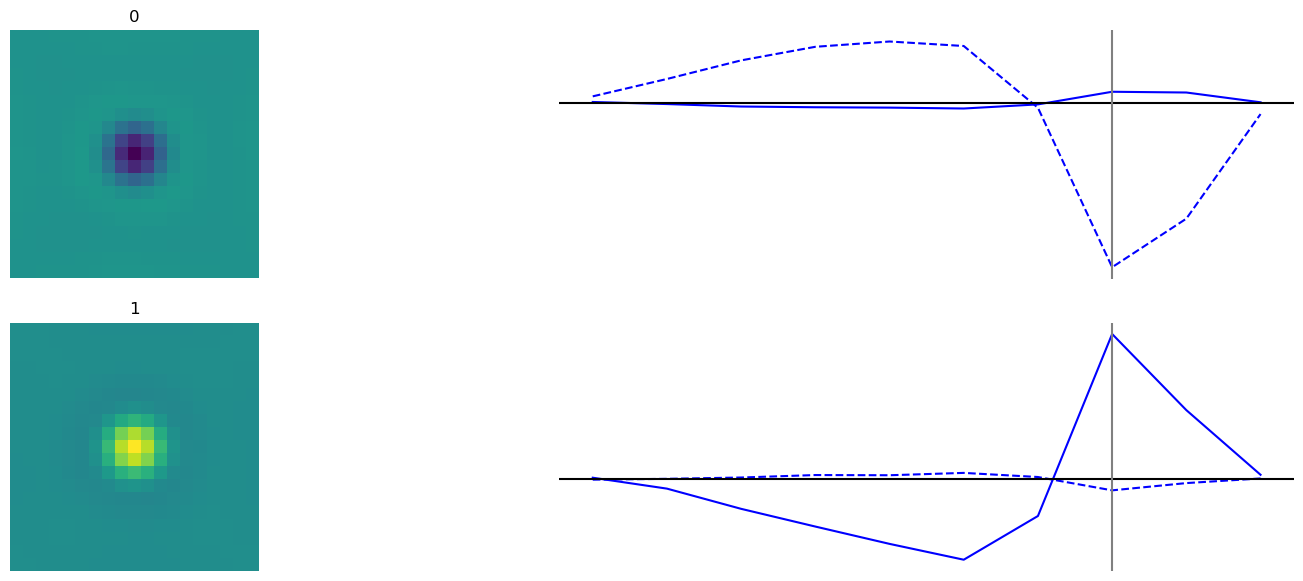

In [23]:
cnn.plot_filters()

In [24]:
filters1 = cnn.get_weights(ffnet_target=0,layer_target=1)
ei_mask_layer1 = deepcopy(cnn.networks[0].layers[1]._ei_mask).detach().cpu().numpy()
ei_mask_layer2 = deepcopy(cnn.networks[0].layers[3]._ei_mask).detach().cpu().numpy()
print(filters1.shape)
print(ei_mask_layer1.shape)
print(ei_mask_layer2.shape)

(2, 19, 19, 12)
(72,)
(48,)


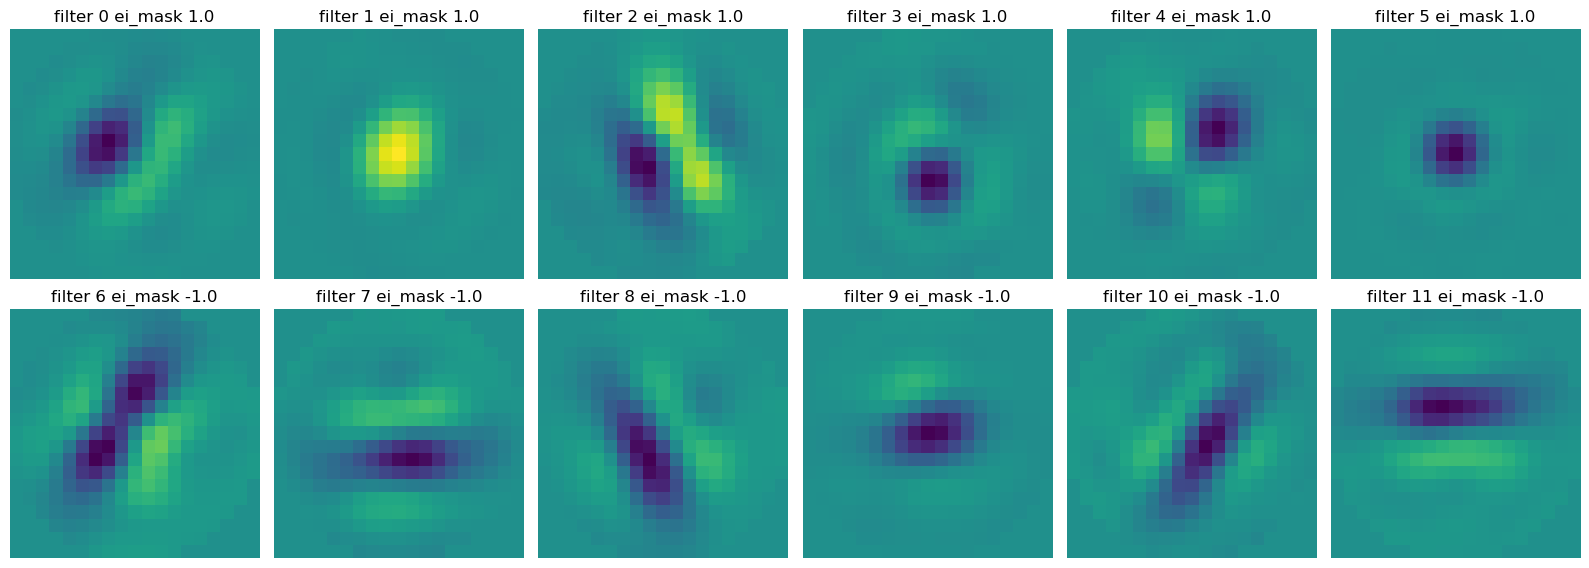

In [25]:
ss(2,6)
for i in range(12):
    plt.subplot(2,6,i+1)
    imagesc(filters1[0,:,:,i], balanced=True)
    plt.title('filter '+str(i)+' ei_mask '+str(ei_mask_layer1[i]))
    plt.axis('off')
plt.tight_layout()
#plt.savefig('/home/ifernand/Desktop/filters.png')
plt.show()

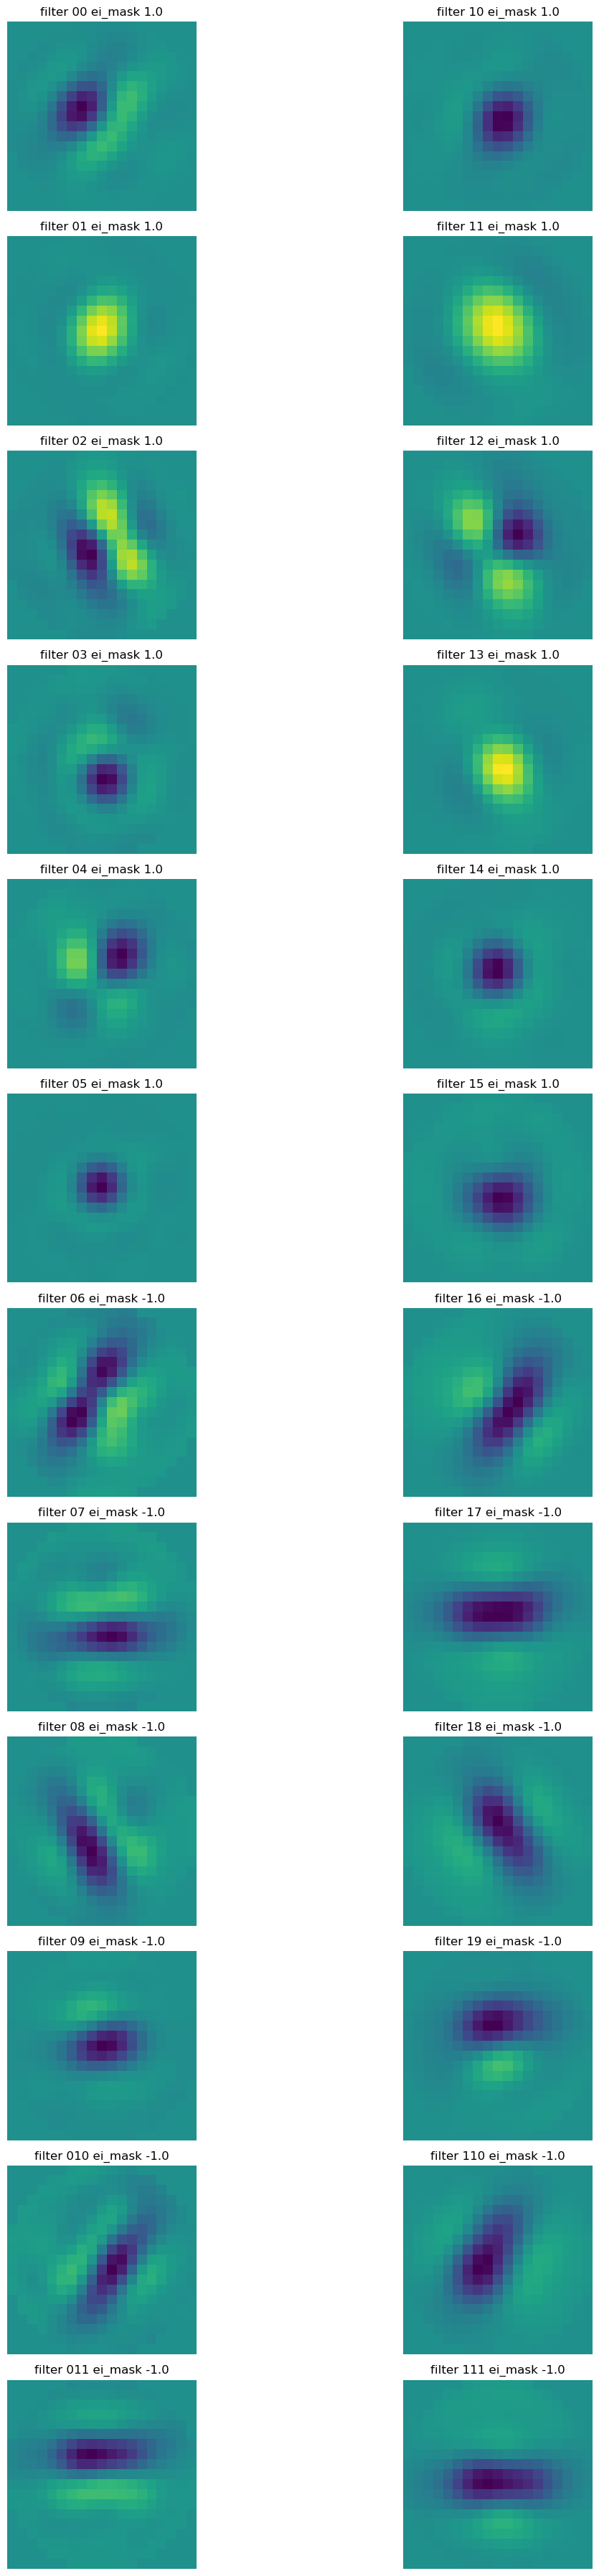

In [17]:
ss(12,2)
k=1
for i in range(12):
    for j in range(2):
        plt.subplot(12,2,k)
        imagesc(filters1[j,:,:,i], balanced=True)
        plt.title('filter '+str(j)+str(i)+' ei_mask '+str(ei_mask_layer1[i]))
        plt.axis('off')
        k+=1
plt.tight_layout()
#plt.savefig('/home/ifernand/Desktop/filters.png')
plt.show()

In [26]:
# Readout Weights (i.e. Barcodes)
full_ei_mask = np.concatenate((ei_mask_layer1[:12], ei_mask_layer2[:8]))
readout_w = cnn.get_weights(ffnet_target=1)
print(readout_w.shape)
print(full_ei_mask.shape)

(20, 794)
(20,)


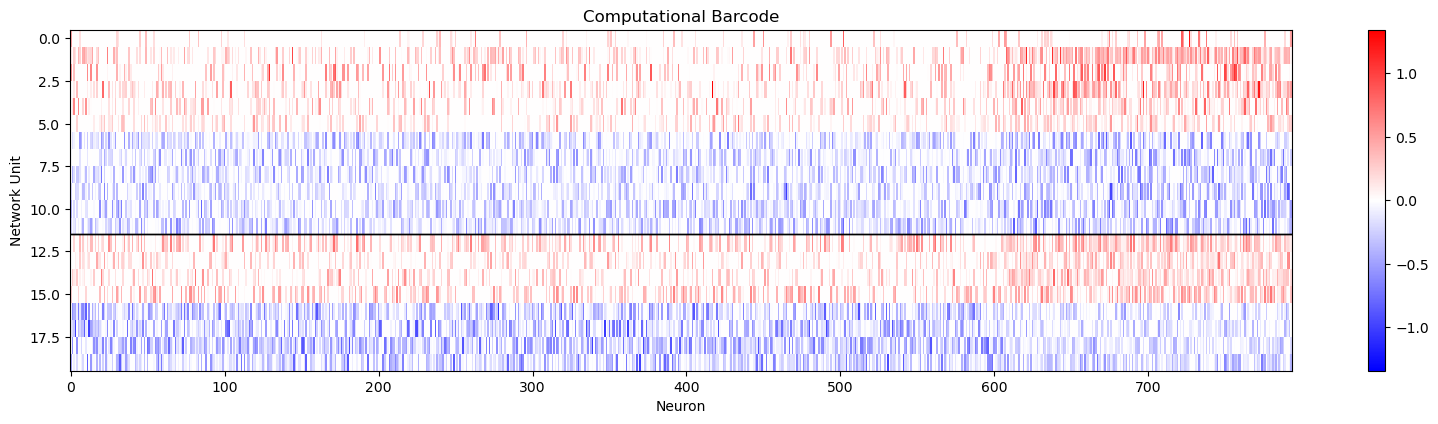

In [27]:
ss(rh=4)
imagesc((readout_w*full_ei_mask.reshape(full_ei_mask.shape[0],1)).T, cmap='bwr')
plt.axhline(y=ei_mask_layer1[:12].shape[0]-0.5, color='black', lw=1)
plt.axhline(y=ei_mask_layer1[:12].shape[0]-0.5, color='black', lw=1)
plt.title('Computational Barcode')
plt.ylabel('Network Unit')
plt.xlabel('Neuron')
plt.colorbar()

In [28]:
readout_similarity = cos_similarity(readout_w) 

Text(0.5, 1.0, 'Cos Similarity Matrix')

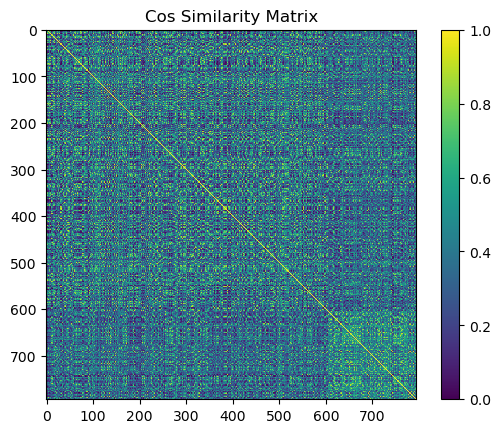

In [29]:
imagesc(readout_similarity)
plt.colorbar()
plt.clim(0,1)
#plt.axvline(x=L4_exc_idx[-1], color='black', lw=2)
#plt.axhline(y=L4_exc_idx[-1], color='black', lw=2)
plt.title('Cos Similarity Matrix')

In [30]:
unique_cos_sim = readout_similarity[np.triu_indices(NC, k = 1)]

In [31]:
L4_exc_readout_similarity = readout_similarity[:L4_exc_idx[-1]+1,:L4_exc_idx[-1]+1]
L4_exc_unique_cos_sim = L4_exc_readout_similarity[np.triu_indices(len(L4_exc_idx), k = 1)]

L4_inh_readout_similarity = readout_similarity[L4_exc_idx[-1]+1:,L4_exc_idx[-1]+1:]
L4_inh_unique_cos_sim = L4_inh_readout_similarity[np.triu_indices(len(L4_inh_idx), k = 1)]

inh_v_exc_cos_sim = readout_similarity[L4_inh_idx[0]:, :L4_exc_idx[-1]+1].reshape((len(L4_exc_idx)*len(L4_inh_idx)))

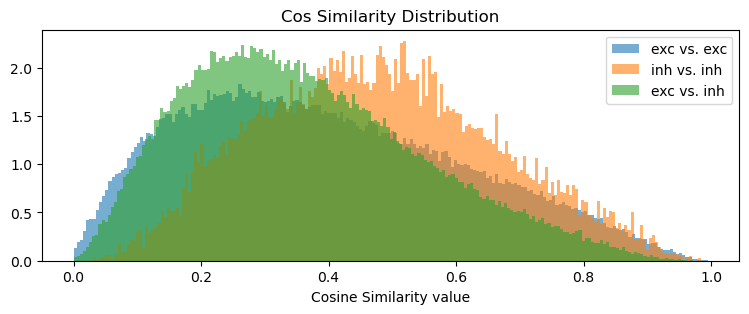

In [32]:
plt.figure(figsize=(9,3))
plt.hist(L4_exc_unique_cos_sim, bins=200, label='exc vs. exc', alpha=0.6, density=True)
plt.hist(L4_inh_unique_cos_sim, bins=200, label='inh vs. inh', alpha=0.6, density=True)
plt.hist(inh_v_exc_cos_sim, bins=200, label='exc vs. inh', alpha=0.6, density=True)
plt.title('Cos Similarity Distribution')
plt.xlabel('Cosine Similarity value')
plt.legend()
plt.show()

In [86]:
from sklearn import metrics
unique_mapping = {string: idx for idx, string in enumerate(set(L4_cell_key))}
integer_list = [unique_mapping[string] for string in L4_cell_key]

silhouette_score =  metrics.silhouette_score( readout_w.T, np.array(integer_list), metric="cosine", sample_size=NC)
print(silhouette_score)

silhouette_score_per_call =  metrics.silhouette_samples( readout_w.T, np.array(integer_list), metric="cosine")

0.07785848


In [35]:
filt_count = np.sum(readout_w > 0.001, axis=0)
filt_count_layer1 = np.sum(readout_w[:12,:] > 0.001, axis=0)
filt_count_layer2 = np.sum(readout_w[12:,:] > 0.001, axis=0)
filt_count.shape

(794,)

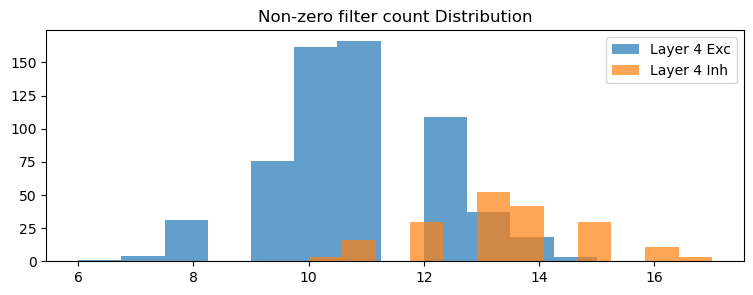

In [37]:
plt.figure(figsize=(9,3))
plt.hist(filt_count[L4_exc_idx] ,bins=12, label='Layer 4 Exc', alpha=0.7)
plt.hist(filt_count[L4_inh_idx] ,bins=12, label='Layer 4 Inh', alpha=0.7)
plt.title('Non-zero filter count Distribution')
plt.legend()
plt.show()

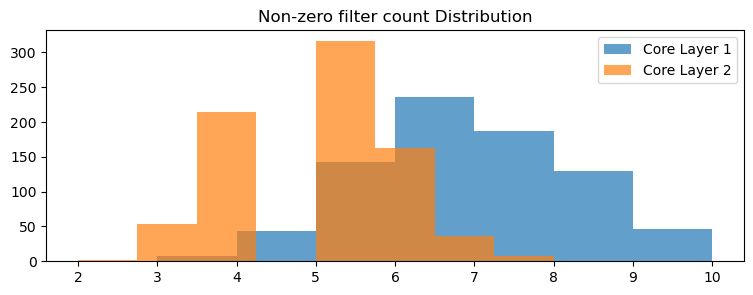

In [38]:
plt.figure(figsize=(9,3))
plt.hist(filt_count_layer1 ,bins=8, label='Core Layer 1', alpha=0.7)
plt.hist(filt_count_layer2 ,bins=8, label='Core Layer 2', alpha=0.7)
plt.title('Non-zero filter count Distribution')
plt.legend()
plt.show()

In [39]:
L4_exc_cell_count = np.mean(readout_w[:,L4_exc_idx]*full_ei_mask.reshape(full_ei_mask.shape[0],1), axis=1) #np.mean(readout_w[:,L4_exc_idx], axis=1)
print(L4_exc_cell_count.shape)

L4_inh_cell_count = np.mean(readout_w[:,L4_inh_idx]*full_ei_mask.reshape(full_ei_mask.shape[0],1), axis=1) #np.mean(readout_w[:,L4_inh_idx], axis=1)
print(L4_inh_cell_count.shape)

(20,)
(20,)


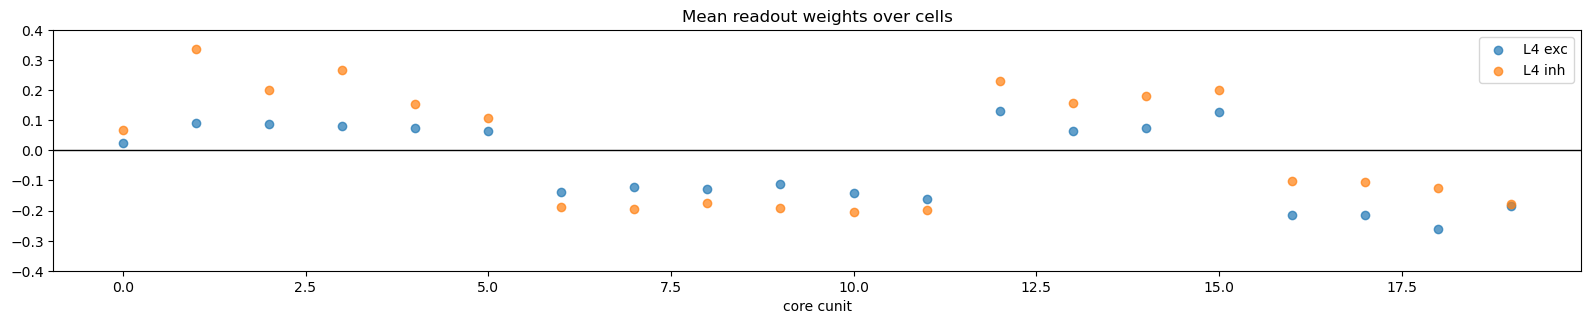

In [41]:
ss()
plt.scatter(np.arange(20), L4_exc_cell_count, label='L4 exc', alpha=0.7)
plt.scatter(np.arange(20), L4_inh_cell_count, label='L4 inh', alpha=0.7)
plt.axhline(y=0, color='black', lw=1)
plt.title('Mean readout weights over cells')
plt.xlabel('core cunit')
plt.ylim([-0.4,0.4])
plt.legend()

In [43]:
filters2 = cnn.get_weights(ffnet_target=0,layer_target=3)
print(filters2.shape)

weight_dist_layer2 = np.zeros((filters2.shape[-1],filters2.shape[0]))
for i in range(filters2.shape[-1]):
    weight_dist_layer2[i,:] = np.mean((filters2[:,:,:,i]*filters2[:,:,:,i]), axis=(1,2))
print(weight_dist_layer2.shape)

(12, 5, 5, 8)
(8, 12)


Text(162.59722222222223, 0.5, 'Mean Squared Layer 2 Weights')

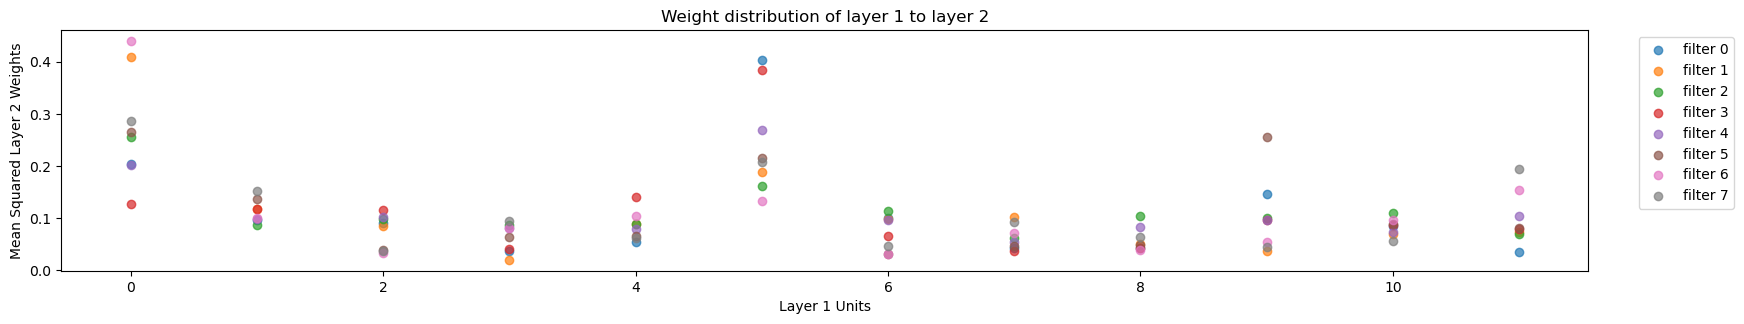

In [44]:
ss()
for i in range(filters2.shape[-1]):
    plt.scatter(np.arange(filters2.shape[0]),weight_dist_layer2[i,:], label='filter '+str(i), alpha=0.7)
plt.legend(loc='upper right',bbox_to_anchor=(1.1, 1.0))
plt.title("Weight distribution of layer 1 to layer 2")
plt.xlabel('Layer 1 Units')
plt.ylabel('Mean Squared Layer 2 Weights')

Text(162.59722222222223, 0.5, 'Mean Squared Layer 2 Weights')

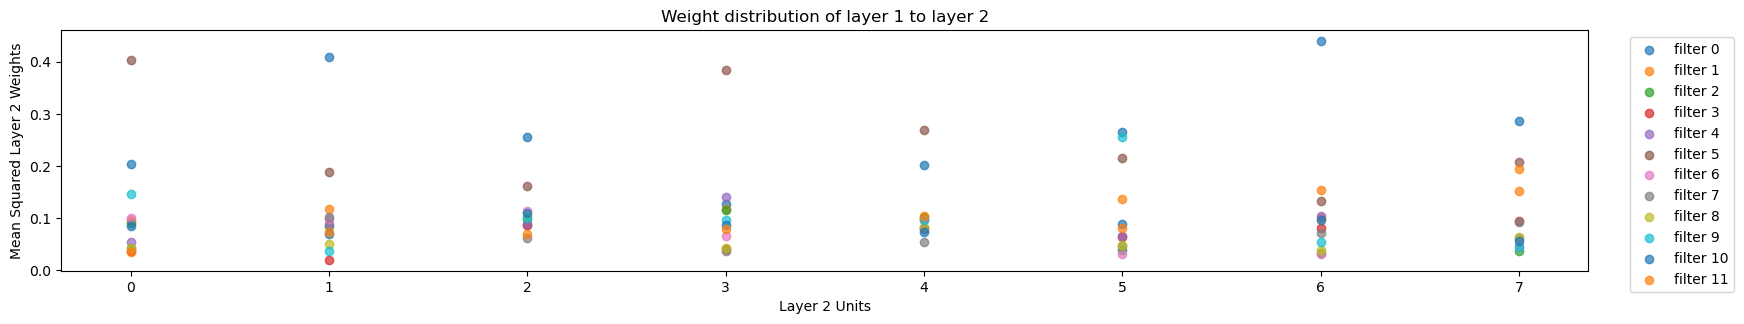

In [45]:
ss()
for i in range(filters2.shape[0]):
    plt.scatter(np.arange(filters2.shape[-1]),weight_dist_layer2[:,i], label='filter '+str(i), alpha=0.7)
plt.legend(loc='upper right',bbox_to_anchor=(1.1, 1.0))
plt.title("Weight distribution of layer 1 to layer 2")
plt.xlabel('Layer 2 Units')
plt.ylabel('Mean Squared Layer 2 Weights')

## Fit Readout

In [61]:
# Chose by sum - need to remove self sim value
L4_exc_sim_sum = np.sum(L4_exc_readout_similarity, axis=0)/np.max(L4_exc_readout_similarity, axis=0)
L4_exc_sim_sort = np.argsort(L4_exc_sim_sum)
L4_inh_sim_sum = np.sum(L4_inh_readout_similarity, axis=0)/np.max(L4_inh_readout_similarity, axis=0)
L4_inh_sim_sort = np.argsort(L4_inh_sim_sum)

In [95]:
# Chose similarity to a good cell
good_cell = np.argmax(LL[L4_exc_idx])
good_cell_sim = L4_exc_readout_similarity[:,good_cell]

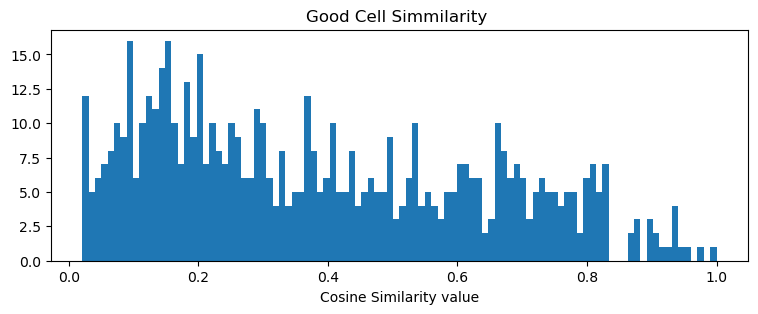

In [96]:
plt.figure(figsize=(9,3))
plt.hist(good_cell_sim, bins=100)
plt.title('Good Cell Simmilarity ')
plt.xlabel('Cosine Similarity value')
plt.show()

In [102]:
cells = np.where(good_cell_sim < 0.04)[0]
cells.shape

(17,)

In [103]:
glms_dict1 = {}
LL_dict1 = {}
for i in range(len(angles)):
    glms, readout_fit_LLs = fit_readout_glms_LL(data, cnn, cells=cells, reg_vals=None, Qmu_idx=i,
                                            val_inds=data.val_blks, train_inds=data.train_blks, 
                                            batch_size=2, chunk_size=10, 
                                            device=device)
    glms_dict1['mu_'+str(i)] = glms
    LL_dict1['mu_'+str(i)] = readout_fit_LLs

  Batch #0:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [01:16<00:00,  3.33it/s]
10it [02:41, 16.16s/it]


  Batch #1:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [01:18<00:00,  3.26it/s]
7it [01:44, 14.91s/it]


  Batch #0:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [01:18<00:00,  3.26it/s]
10it [02:35, 15.54s/it]


  Batch #1:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [01:18<00:00,  3.26it/s]
7it [01:41, 14.51s/it]


  Batch #0:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [01:18<00:00,  3.25it/s]
10it [02:39, 15.97s/it]


  Batch #1:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [01:18<00:00,  3.24it/s]
7it [01:43, 14.83s/it]


  Batch #0:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [01:18<00:00,  3.27it/s]
10it [02:39, 15.90s/it]


  Batch #1:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [01:16<00:00,  3.33it/s]
7it [01:41, 14.52s/it]


  Batch #0:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [01:18<00:00,  3.26it/s]
10it [02:37, 15.74s/it]


  Batch #1:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [01:18<00:00,  3.24it/s]
7it [01:42, 14.63s/it]


  Batch #0:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [01:18<00:00,  3.24it/s]
10it [02:40, 16.03s/it]


  Batch #1:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [01:16<00:00,  3.35it/s]
7it [01:41, 14.55s/it]


In [104]:
fit_NC = len(glms_dict1['mu_0'])
print(fit_NC)

17


In [105]:
max_mu = np.zeros(fit_NC)
for i in range(fit_NC):
    LL_cell_arr = np.zeros(6)
    for k in range(6):
        LL_cell_arr[k] = LL_dict1['mu_'+str(k)][i][0]
    max_mu[i] = np.argmax(LL_cell_arr)
print(max_mu)

new_mus = degrees2mu(max_mu*30, angles)
print(new_mus)

[1. 1. 3. 3. 2. 3. 3. 3. 3. 3. 3. 4. 3. 2. 1. 3. 2.]
[-0.5        -0.5         0.16666667  0.16666667 -0.16666667  0.16666667
  0.16666667  0.16666667  0.16666667  0.16666667  0.16666667  0.5
  0.16666667 -0.16666667 -0.5         0.16666667 -0.16666667]


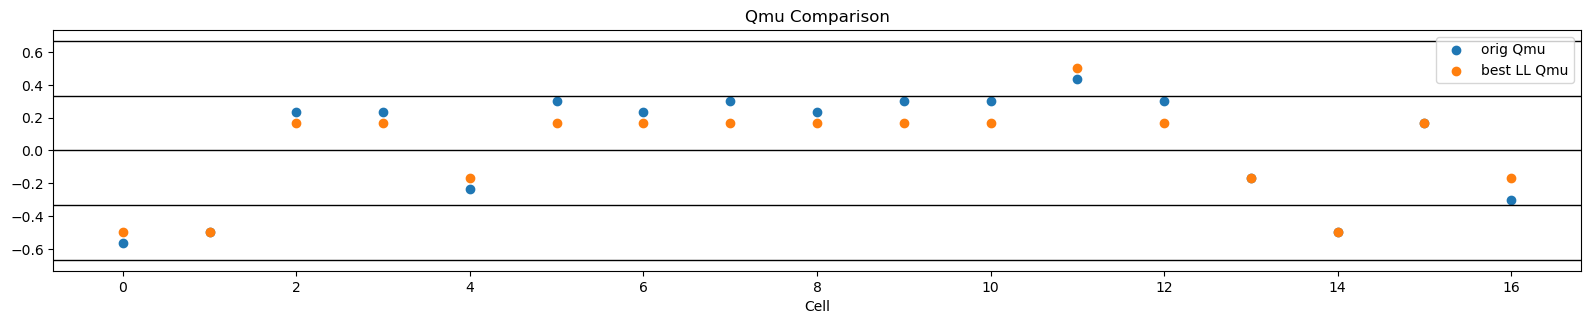

In [106]:
ss()
plt.scatter(np.arange(fit_NC), Qmu0s[cells], label='orig Qmu')
plt.scatter(np.arange(fit_NC), new_mus, label='best LL Qmu')
for i in range(1,6):
    plt.axhline(y=-1+(i*(2/6)), color='black', lw=1)
plt.title('Qmu Comparison')
plt.xlabel('Cell')
plt.legend(loc='upper right')
plt.show()

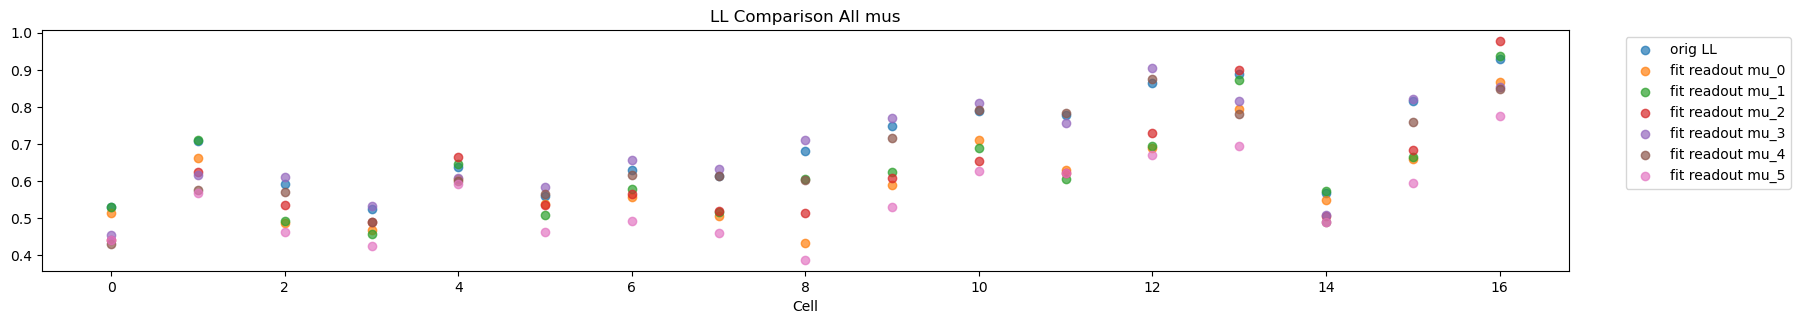

In [107]:
ss()
plt.scatter(np.arange(fit_NC),LL[cells], label='orig LL', alpha=0.7)
for i in range(6):
    plt.scatter(np.arange(fit_NC), LL_dict1['mu_'+str(i)], label='fit readout mu_'+str(i), alpha=0.7)
plt.title('LL Comparison All mus')
plt.xlabel('Cell')
plt.legend(loc='upper right',bbox_to_anchor=(1.15, 1.0))
plt.show()

In [108]:
max_LL = np.zeros(fit_NC)
for i in range(10):
    max_LL[i] = LL_dict1['mu_'+str(int(max_mu[i]))][i][0]
print(max_LL)

[0.53135252 0.70997047 0.61202216 0.53350687 0.66617918 0.58343983
 0.65741348 0.633793   0.70979357 0.77049255 0.         0.
 0.         0.         0.         0.         0.        ]


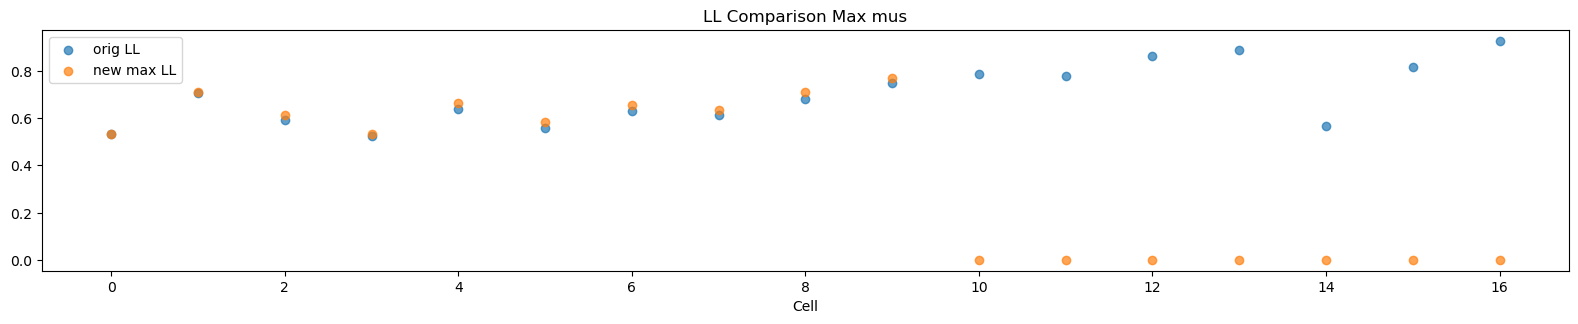

In [109]:
ss()
plt.scatter(np.arange(fit_NC),LL[cells], label='orig LL', alpha=0.7)
plt.scatter(np.arange(fit_NC), max_LL, label='new max LL', alpha=0.7)
plt.title('LL Comparison Max mus')
plt.xlabel('Cell')
plt.legend()
plt.show()

In [113]:
new_readout_w = deepcopy(readout_w)
for i in range(fit_NC):
    j = cells[i]
    new_readout_w[:,j] = glms_dict1['mu_'+str(int(max_mu[i]))][i].get_weights().squeeze()

In [120]:
new_readout_similarity = cos_similarity(new_readout_w)
new_L4_exc_readout_similarity = new_readout_similarity[:L4_exc_idx[-1]+1,:L4_exc_idx[-1]+1]
new_good_cell_sim = new_L4_exc_readout_similarity[:,good_cell]

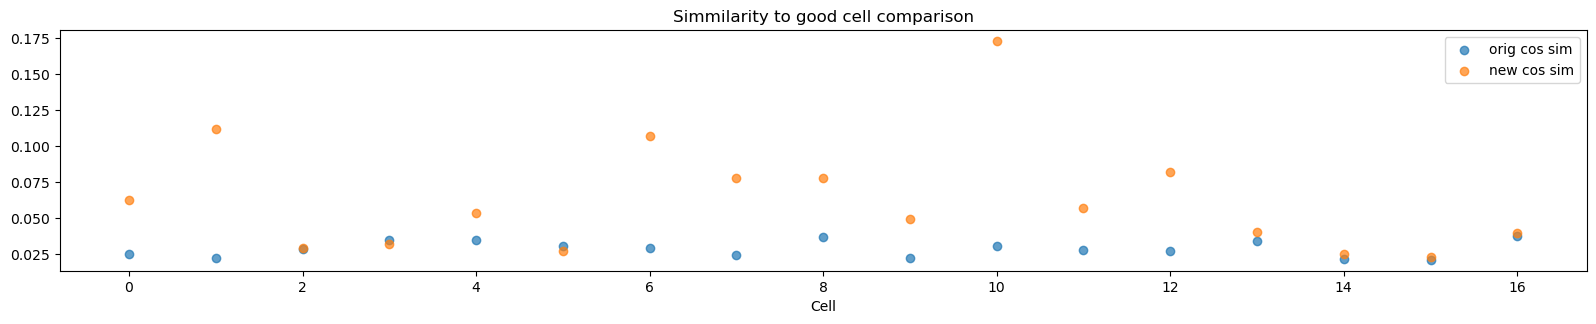

In [119]:
ss()
plt.scatter(np.arange(fit_NC), good_cell_sim[cells], label='orig cos sim', alpha=0.7)
plt.scatter(np.arange(fit_NC), new_good_cell_sim[cells], label='new cos sim', alpha=0.7)
plt.title('Simmilarity to good cell comparison')
plt.xlabel('Cell')
plt.legend()
plt.show()

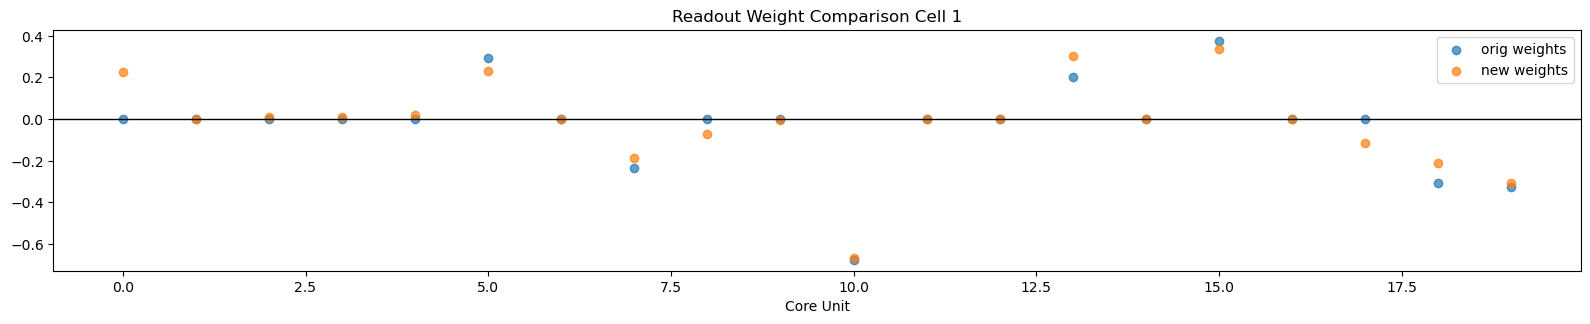

In [122]:
ss()
cc = 1
plt.scatter(np.arange(20),readout_w[:,cells[cc]]*full_ei_mask, label='orig weights', alpha=0.7)
i = int(max_mu[cc])
plt.scatter(np.arange(20),glms_dict1['mu_'+str(i)][cc].get_weights()[:,0]*full_ei_mask, label='new weights', alpha=0.7)
plt.title('Readout Weight Comparison Cell '+str(cc))
plt.xlabel('Core Unit')
plt.axhline(y=0, color='black', lw=1)
plt.legend()
plt.show()